<a href="https://colab.research.google.com/github/mxm4340/2/blob/main/H2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
### Dear TA: this is HW2 Neural Network First step, I create .ipynb and it in several steps (Thank you, Mohsen)
### Run time for whole document is around 20 minutes
import numpy as np
class Layer:
    def forward(self, input):
        raise NotImplementedError
    def backward(self, grad_output):
        raise NotImplementedError
class Linear(Layer):
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.W = np.random.randn(output_dim, input_dim) * np.sqrt(2.0 / input_dim)
        self.b = np.zeros((output_dim,))
    def forward(self, input):
        self.input = input
        self.output = np.dot(input, self.W.T) + self.b
        return self.output
    def backward(self, grad_output):
        self.dW = np.dot(grad_output.T, self.input)
        self.db = np.sum(grad_output, axis=0)
        grad_input = np.dot(grad_output, self.W)
        return grad_input
    def update_params(self, learning_rate):
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db
class Sigmoid(Layer):
    def forward(self, input):
        self.out = 1.0 / (1.0 + np.exp(-input))
        return self.out
    def backward(self, grad_output):
        sigmoid_grad = self.out * (1 - self.out)
        return grad_output * sigmoid_grad
class Tanh(Layer):
    def forward(self, input):
        self.out = np.tanh(input)
        return self.out
    def backward(self, grad_output):
        return grad_output * (1 - self.out ** 2)
class ReLU(Layer):
    def forward(self, input):
        self.input = input
        self.out = np.maximum(0, input)
        return self.out
    def backward(self, grad_output):
        grad_input = grad_output.copy()
        grad_input[self.input <= 0] = 0
        return grad_input
class BinaryCrossEntropyLoss(Layer):
    def forward(self, predictions, targets):
        epsilon = 1e-12
        self.predictions = np.clip(predictions, epsilon, 1 - epsilon)
        self.targets = targets
        loss = - (targets * np.log(self.predictions) + (1 - targets) * np.log(1 - self.predictions))
        return np.mean(loss)
    def backward(self):
        epsilon = 1e-12
        grad = (-(self.targets) / (self.predictions + epsilon) +
                (1 - self.targets) / (1 - self.predictions + epsilon))
        grad = grad / self.targets.shape[0]
        return grad
class MSELoss(Layer):
    def forward(self, predictions, targets):
        self.predictions = predictions
        self.targets = targets
        loss = np.mean((predictions - targets) ** 2)
        return loss
    def backward(self):
        grad = 2 * (self.predictions - self.targets) / self.targets.shape[0]
        return grad
class Sequential(Layer):
    def __init__(self, layers):
        self.layers = layers
    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input
    def backward(self, grad_output):
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)
        return grad_output
    def update_params(self, learning_rate):
        for layer in self.layers:
            if hasattr(layer, 'update_params'):
                layer.update_params(learning_rate)
    def save_weights(self, filename):
        params = {}
        for idx, layer in enumerate(self.layers):
            if hasattr(layer, 'W'):
                params[f'layer_{idx}_W'] = layer.W
                params[f'layer_{idx}_b'] = layer.b
        np.savez(filename, **params)
    def load_weights(self, filename):
        data = np.load(filename)
        for idx, layer in enumerate(self.layers):
            if hasattr(layer, 'W'):
                layer.W = data[f'layer_{idx}_W']
                layer.b = data[f'layer_{idx}_b']
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))
def train_xor(activation_type='sigmoid', epochs=10000, learning_rate=0.1):
    print(f"Training XOR with {activation_type} activation in the hidden layer.")
    X = np.array([
        [0, 0],
        [0, 1],
        [1, 0],
        [1, 1]
    ])
    y = np.array([[0], [1], [1], [0]])
    if activation_type == 'sigmoid':
        hidden_activation = Sigmoid()
    elif activation_type == 'tanh':
        hidden_activation = Tanh()
    else:
        raise ValueError("Unsupported activation type")
    model = Sequential([
        Linear(2, 2),
        hidden_activation,
        Linear(2, 1),
        Sigmoid()
    ])
    loss_fn = BinaryCrossEntropyLoss()
    for epoch in range(epochs):
        output = model.forward(X)
        loss = loss_fn.forward(output, y)
        grad_loss = loss_fn.backward()
        model.backward(grad_loss)
        model.update_params(learning_rate)
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")
        if loss < 0.01:
            print(f"Converged at epoch {epoch}, Loss: {loss:.4f}")
            break
    model.save_weights("XOR_solved.w")
    predictions = model.forward(X)
    print("Final Predictions on XOR input:")
    print(predictions)
    return model
def train_taxi():
    print("Training Taxi Trip Duration Model")
    data_path = '/Users/mohsenmohammadagha/Desktop/P/nyc_taxi_data.npy'
    dataset = np.load(data_path, allow_pickle=True).item()
    X_train, y_train = dataset["X_train"], dataset["y_train"]
    X_test, y_test = dataset["X_test"], dataset["y_test"]
    print("Dataset Type:", type(dataset))
    print("X_train Shape:", np.shape(X_train))
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0) + 1e-6
    X_train_norm = (X_train - mean) / std
    X_test_norm = (X_test - mean) / std
    split_idx = int(0.8 * X_train_norm.shape[0])
    X_train_split, y_train_split = X_train_norm[:split_idx], y_train[:split_idx]
    X_val, y_val = X_train_norm[split_idx:], y_train[split_idx:]
    input_dim = X_train_norm.shape[1]
    model = Sequential([
        Linear(input_dim, 100),
        ReLU(),
        Linear(100, 100),
        ReLU(),
        Linear(100, 1)  # Linear output for regression.
    ])
    loss_fn = MSELoss()
    epochs = 50
    learning_rate = 0.001
    best_val_loss = np.inf
    patience = 0
    for epoch in range(epochs):
        predictions_train = model.forward(X_train_split)
        train_loss = loss_fn.forward(predictions_train, y_train_split)
        grad_loss = loss_fn.backward()
        model.backward(grad_loss)
        model.update_params(learning_rate)
        predictions_val = model.forward(X_val)
        val_loss = loss_fn.forward(predictions_val, y_val)
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
        else:
            patience += 1
        if patience >= 3:
            print("Early stopping triggered")
            break
    predictions_test = model.forward(X_test_norm)
    test_loss = loss_fn.forward(predictions_test, y_test)
    test_rmsle = rmsle(y_test, predictions_test)
    print(f"Test MSE Loss: {test_loss:.4f}")
    print(f"Test RMSLE: {test_rmsle:.4f}")
    return model
if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser(description="Neural Network Library Assignment")
    parser.add_argument("--task", choices=["xor", "taxi"], default="xor",
                        help="Task to run: 'xor' for the XOR problem, 'taxi' for taxi trip duration prediction")
    parser.add_argument("--activation", choices=["sigmoid", "tanh"], default="sigmoid",
                        help="Activation function for the hidden layer in the XOR model")
    args, unknown = parser.parse_known_args()
    if args.task == "xor":
        train_xor(activation_type=args.activation)
    elif args.task == "taxi":
        train_taxi()

                                                                               ###Thank you, Mohsen UTA ID=1001874340 Spring 2025

Training XOR with sigmoid activation in the hidden layer.
Epoch 0, Loss: 0.7457
Epoch 1000, Loss: 0.6651
Epoch 2000, Loss: 0.5724
Epoch 3000, Loss: 0.3156
Epoch 4000, Loss: 0.0957
Epoch 5000, Loss: 0.0510
Epoch 6000, Loss: 0.0342
Epoch 7000, Loss: 0.0255
Epoch 8000, Loss: 0.0203
Epoch 9000, Loss: 0.0168
Final Predictions on XOR input:
[[0.01391466]
 [0.98681253]
 [0.98196034]
 [0.01183269]]


In [5]:
import numpy
def xor_dataset(n_samples):
    m, M = 0, 255
    n1 = np.random.randint(m, M)


In [6]:
import numpy as np
import pandas as pd
num_samples = 1000
min_val, max_val = 0, 255
int1 = np.random.randint(min_val, max_val + 1, num_samples)
int2 = np.random.randint(min_val, max_val + 1, num_samples)
xor_result = np.bitwise_xor(int1, int2)
xor_dataset = pd.DataFrame({"Integer1": int1, "Integer2": int2, "XOR": xor_result})
xor_dataset.to_csv("xor_dataset.csv", index=False)
print(xor_dataset.head())

   Integer1  Integer2  XOR
0         0       229  229
1       165        45  136
2        41       239  198
3        37       228  193
4       117        29  104


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


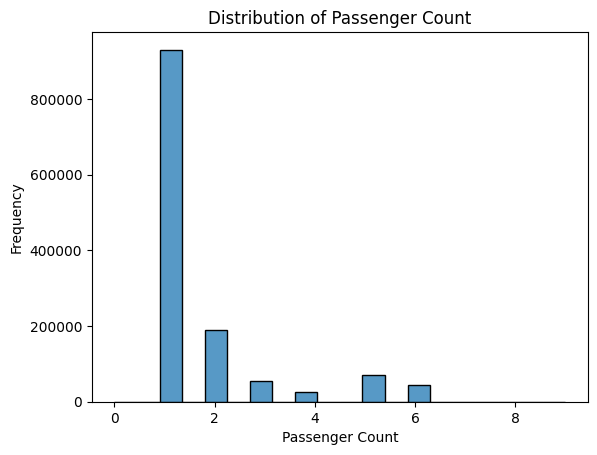

In [10]:
#dataset = np.load("nyc_taxi_data.npy", allow_pickle=True).item()


from google.colab import drive # mount Drive
drive.mount('/content/drive') # approve prompt
dataset = np.load('drive/MyDrive/nyc_taxi_data.npy', allow_pickle=True).item()


df = dataset["X_train"]

import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(df['passenger_count'], bins=20)
plt.title('Distribution of Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


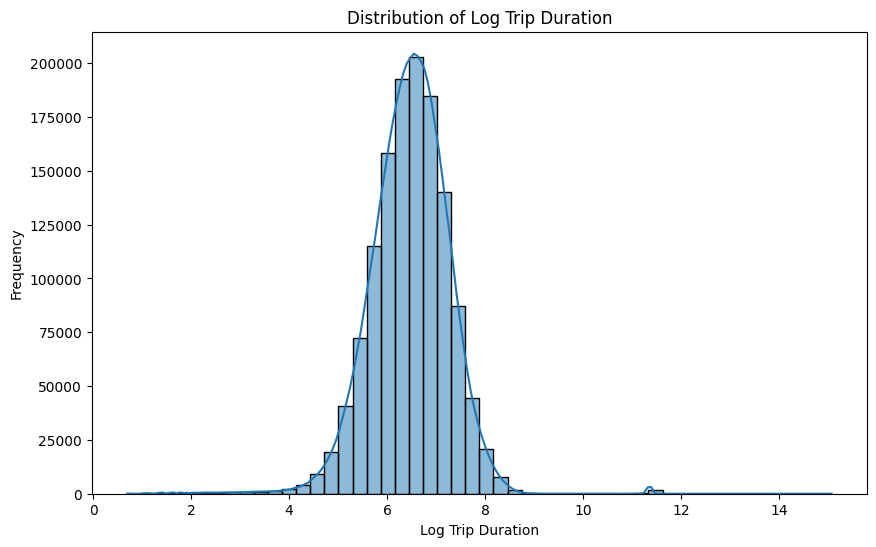

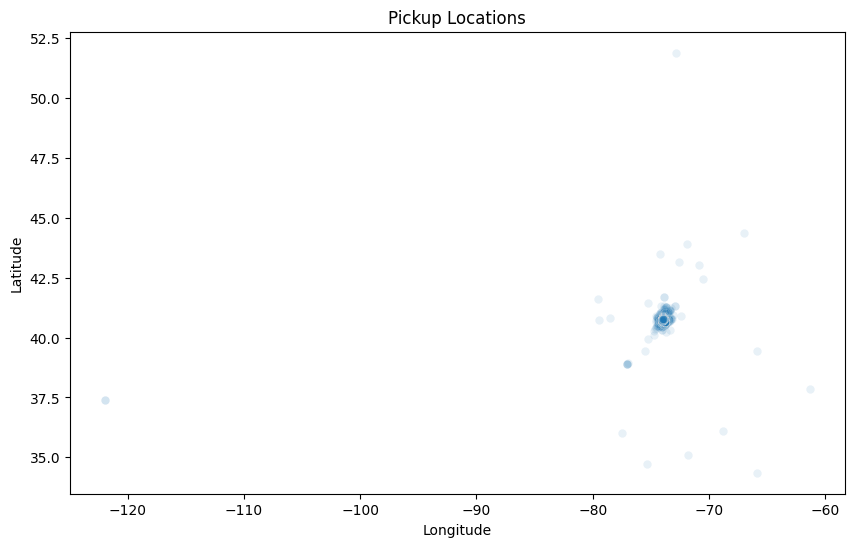

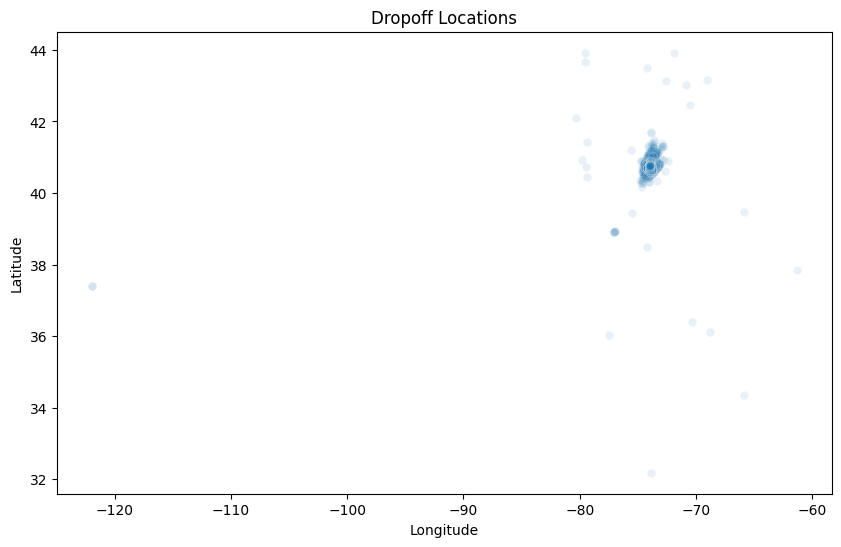

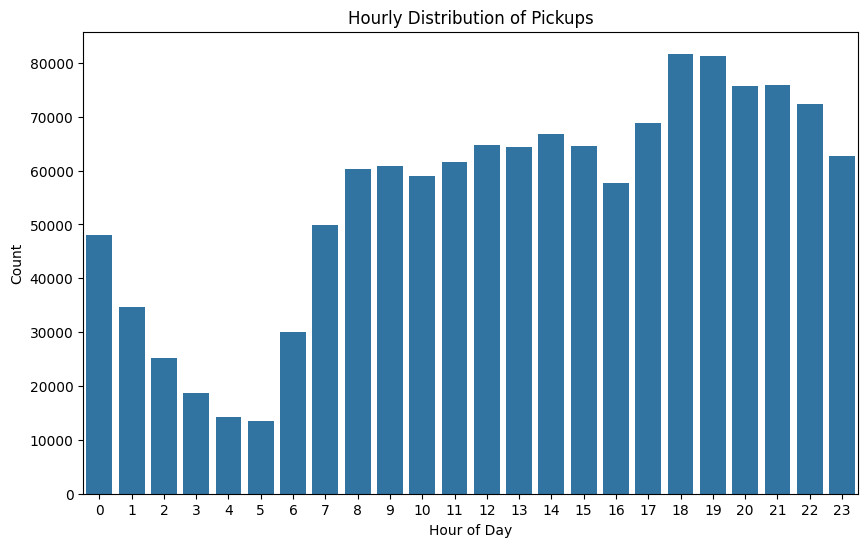

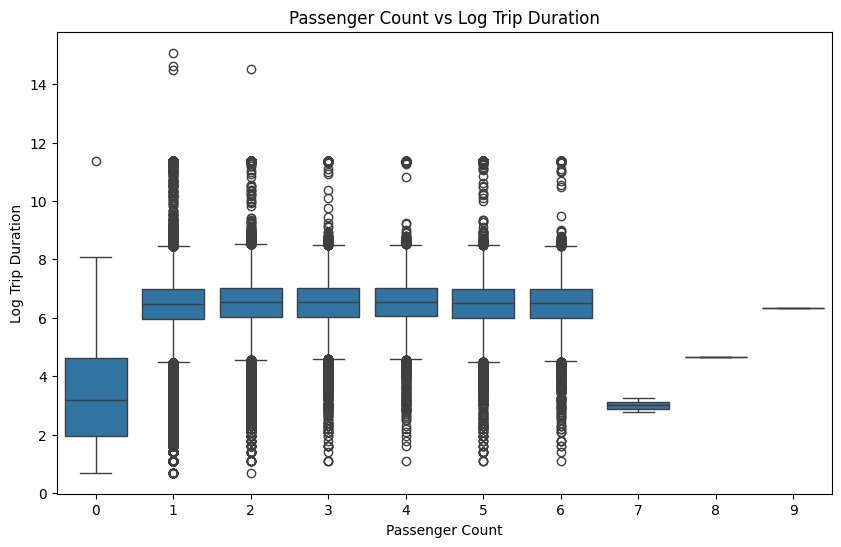

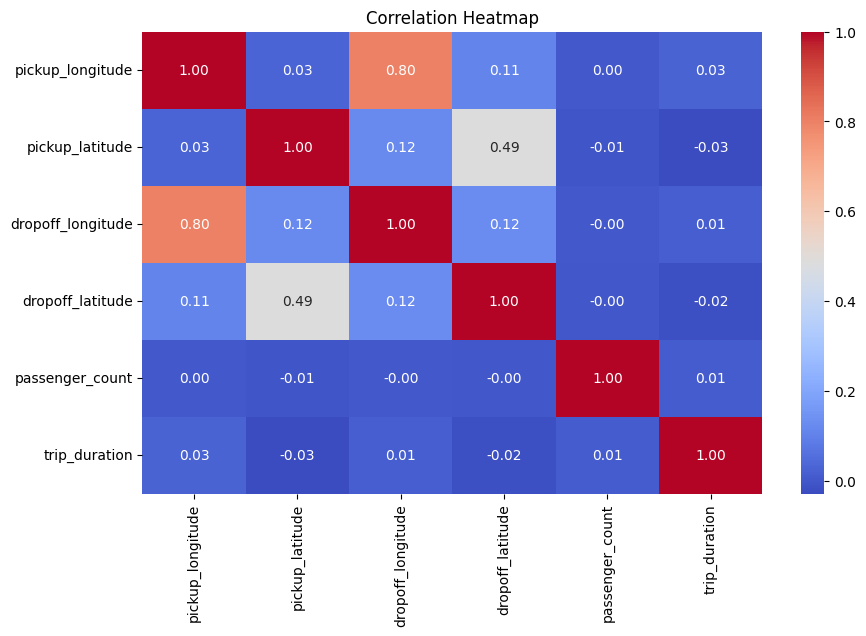

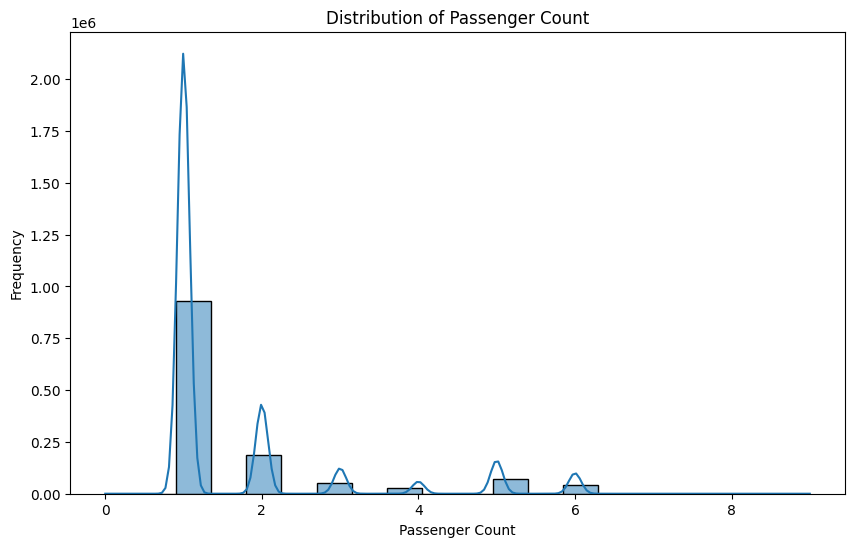

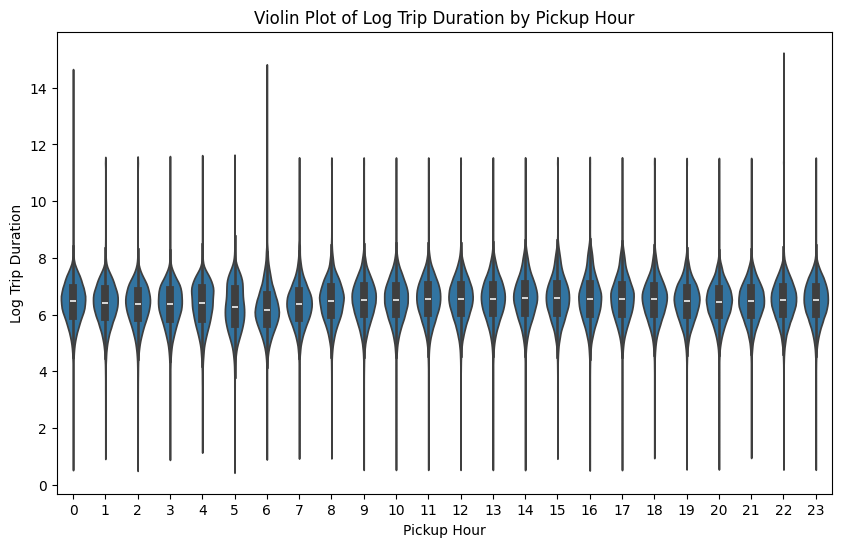

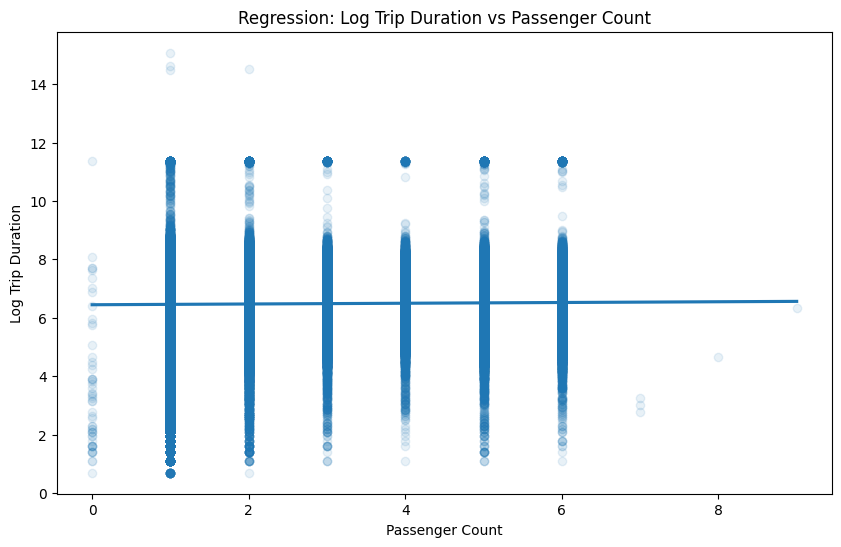

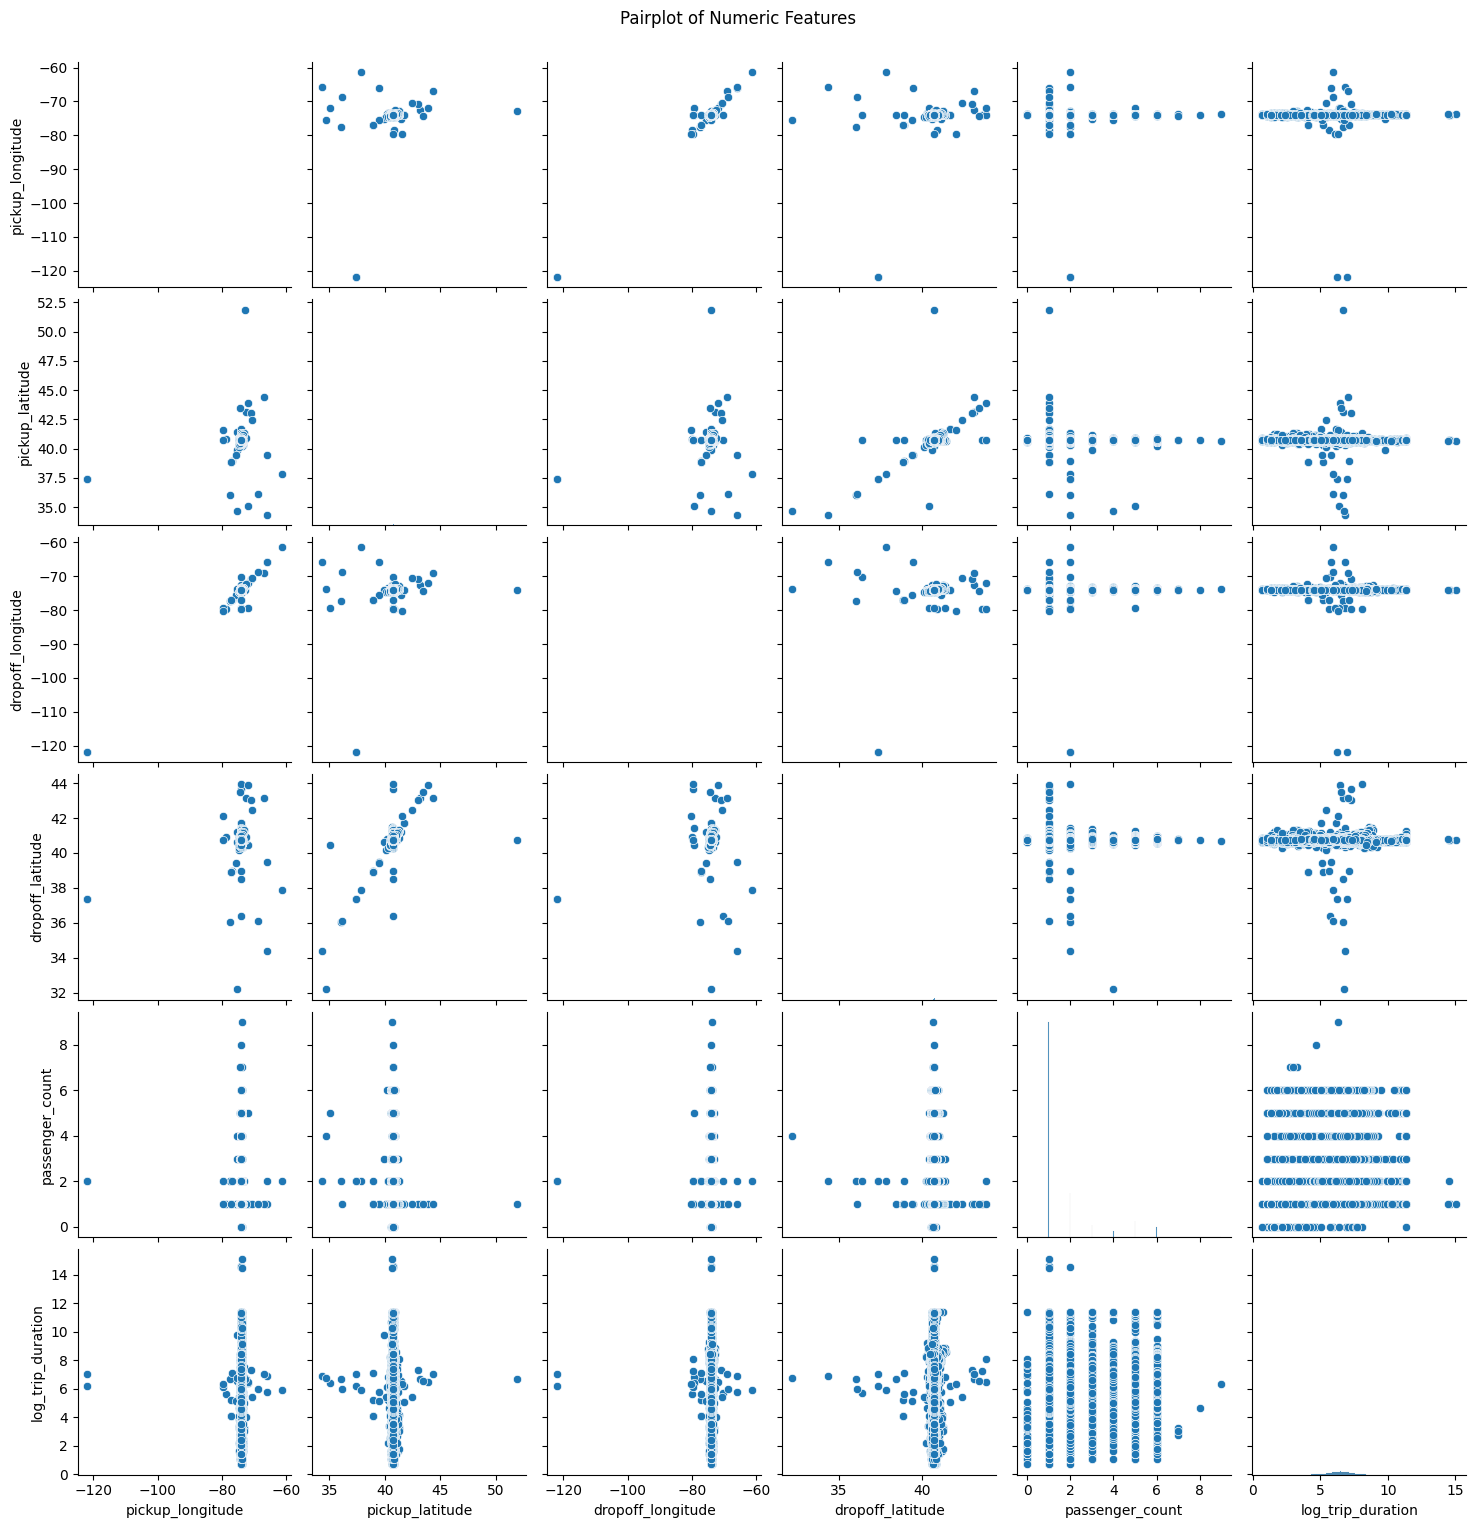

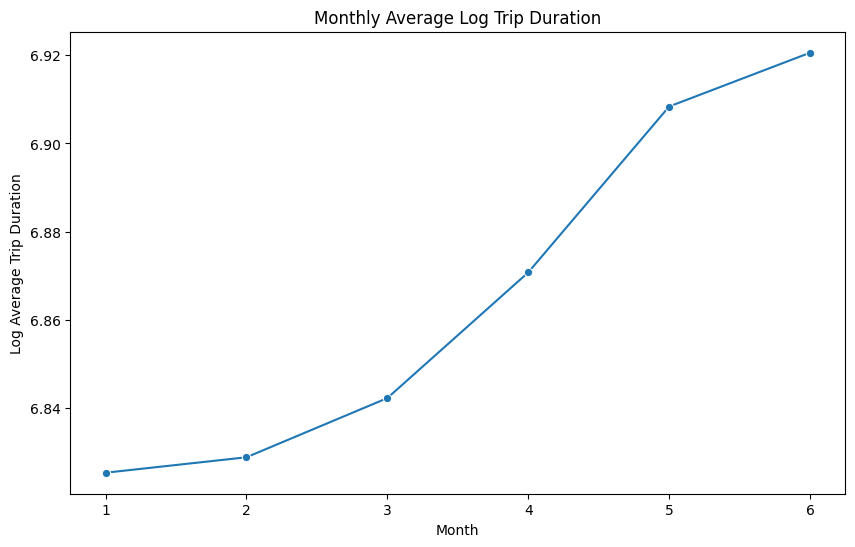

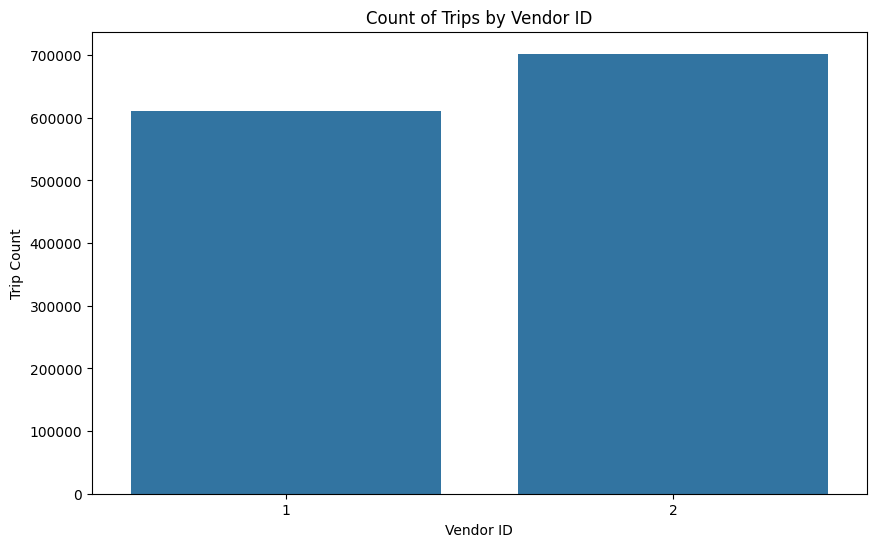

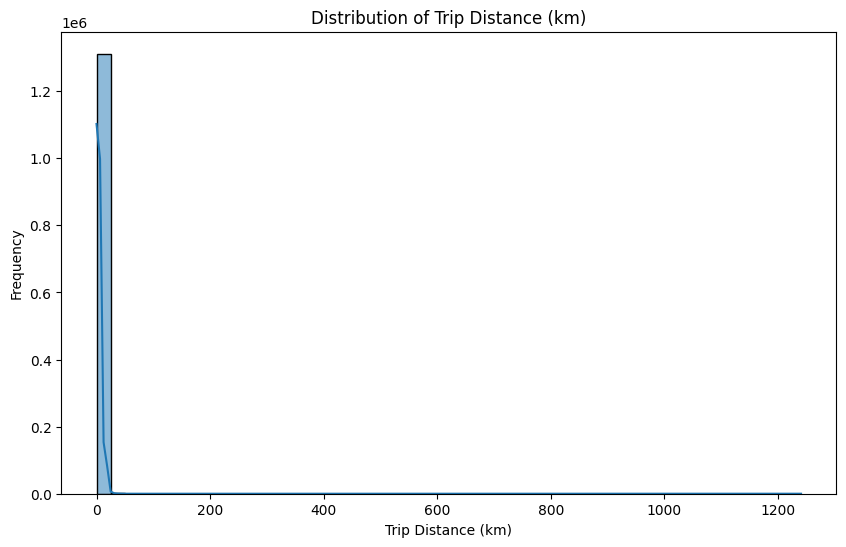

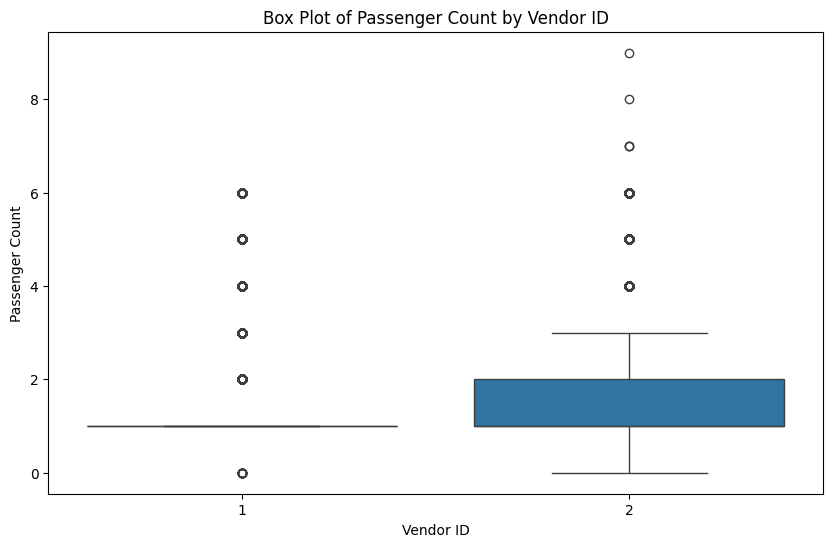

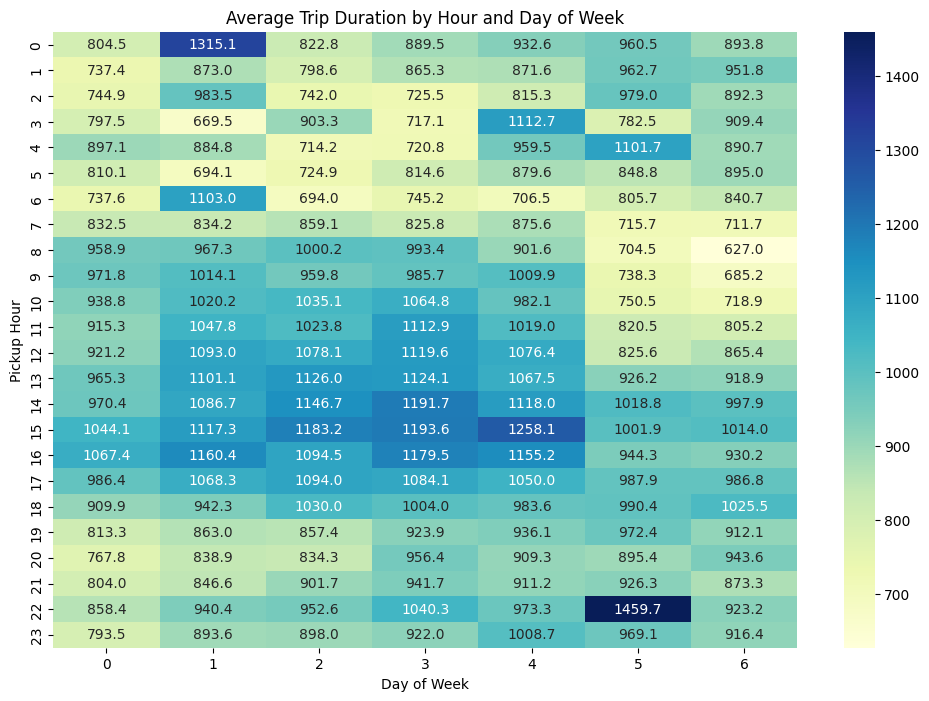


Table 1: Summary Statistics for Numeric Columns
       pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
count      1.312779e+06     1.312779e+06       1.312779e+06      1.312779e+06   
mean      -7.397350e+01     4.075093e+01      -7.397342e+01      4.075181e+01   
std        7.351224e-02     3.291198e-02       7.316118e-02      3.579324e-02   
min       -1.219333e+02     3.435970e+01      -1.219333e+02      3.218114e+01   
25%       -7.399187e+01     4.073735e+01      -7.399133e+01      4.073589e+01   
50%       -7.398174e+01     4.075410e+01      -7.397975e+01      4.075453e+01   
75%       -7.396734e+01     4.076835e+01      -7.396302e+01      4.076980e+01   
max       -6.133553e+01     5.188108e+01      -6.133553e+01      4.392103e+01   

       passenger_count  trip_duration  trip_distance  
count     1.312779e+06   1.312779e+06   1.312779e+06  
mean      1.664126e+00   9.589538e+02   3.440868e+00  
std       1.313950e+00   5.409679e+03   4.302587e+00  
m

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np



from google.colab import drive # mount Drive
drive.mount('/content/drive') # approve prompt
dataset = np.load('drive/MyDrive/nyc_taxi_data.npy', allow_pickle=True).item()

# data_path = "nyc_taxi_data.npy"
# dataset = np.load(data_path, allow_pickle=True).item()




df = dataset["X_train"]
df = pd.DataFrame(df)
y_train = dataset["y_train"]
df = df.copy()     # avoid SettingWithCopyWarning
df["trip_duration"] = y_train  # trip duration in seconds
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df["pickup_hour"] = df["pickup_datetime"].dt.hour
df["pickup_day"] = df["pickup_datetime"].dt.dayofweek  # Monday=0, Sunday=6
df["pickup_month"] = df["pickup_datetime"].dt.month
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df["trip_duration"]), bins=50, kde=True)
plt.title('Distribution of Log Trip Duration')
plt.xlabel('Log Trip Duration')
plt.ylabel('Frequency')
plt.show()
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['pickup_longitude'], y=df['pickup_latitude'], alpha=0.1)
plt.title('Pickup Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['dropoff_longitude'], y=df['dropoff_latitude'], alpha=0.1)
plt.title('Dropoff Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.figure(figsize=(10, 6))
sns.countplot(x=df['pickup_hour'], order=range(24))
plt.title('Hourly Distribution of Pickups')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.show()
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['passenger_count'], y=np.log1p(df['trip_duration']))
plt.title('Passenger Count vs Log Trip Duration')
plt.xlabel('Passenger Count')
plt.ylabel('Log Trip Duration')
plt.show()
numeric_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'trip_duration']
df_numeric = df[numeric_cols]
corr_matrix = df_numeric.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()
plt.figure(figsize=(10, 6))
sns.histplot(df['passenger_count'], bins=20, kde=True)
plt.title('Distribution of Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')
plt.show()
plt.figure(figsize=(10, 6))
sns.violinplot(x=df['pickup_hour'], y=np.log1p(df['trip_duration']))
plt.title('Violin Plot of Log Trip Duration by Pickup Hour')
plt.xlabel('Pickup Hour')
plt.ylabel('Log Trip Duration')
plt.show()
plt.figure(figsize=(10, 6))
sns.regplot(x=df['passenger_count'], y=np.log1p(df['trip_duration']), scatter_kws={'alpha':0.1})
plt.title('Regression: Log Trip Duration vs Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Log Trip Duration')
plt.show()
df_pairplot = df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'trip_duration']].copy()
df_pairplot['log_trip_duration'] = np.log1p(df_pairplot['trip_duration'])
sns.pairplot(df_pairplot.drop(columns=['trip_duration']))
plt.suptitle('Pairplot of Numeric Features', y=1.02)
plt.show()
monthly_avg = df.groupby('pickup_month')['trip_duration'].mean()
plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_avg.index, y=np.log1p(monthly_avg.values), marker='o')
plt.title('Monthly Average Log Trip Duration')
plt.xlabel('Month')
plt.ylabel('Log Average Trip Duration')
plt.show()
plt.figure(figsize=(10, 6))
vendor_counts = df['vendor_id'].value_counts()
sns.barplot(x=vendor_counts.index, y=vendor_counts.values)
plt.title('Count of Trips by Vendor ID')
plt.xlabel('Vendor ID')
plt.ylabel('Trip Count')
plt.show()
R = 6371  # Radius of the earth in km
lat1 = np.radians(df['pickup_latitude'])
lon1 = np.radians(df['pickup_longitude'])
lat2 = np.radians(df['dropoff_latitude'])
lon2 = np.radians(df['dropoff_longitude'])
dlat = lat2 - lat1
dlon = lon2 - lon1
a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
c = 2 * np.arcsin(np.sqrt(a))
df['trip_distance'] = R * c
plt.figure(figsize=(10, 6))
sns.histplot(df['trip_distance'], bins=50, kde=True)
plt.title('Distribution of Trip Distance (km)')
plt.xlabel('Trip Distance (km)')
plt.ylabel('Frequency')
plt.show()
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['vendor_id'], y=df['passenger_count'])
plt.title('Box Plot of Passenger Count by Vendor ID')
plt.xlabel('Vendor ID')
plt.ylabel('Passenger Count')
plt.show()
heatmap_data = df.groupby(['pickup_hour', 'pickup_day'])['trip_duration'].mean().unstack()
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt=".1f")
plt.title('Average Trip Duration by Hour and Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Pickup Hour')
plt.show()
print("\nTable 1: Summary Statistics for Numeric Columns")
print(df[numeric_cols + ['trip_distance']].describe())
print("\nTable 2: Frequency Count for Vendor ID")
vendor_freq = df['vendor_id'].value_counts().to_frame(name='count')
print(vendor_freq)
print("\nTable 3: Average Trip Duration by Vendor ID")
avg_duration_vendor = df.groupby('vendor_id')['trip_duration'].mean().to_frame(name='avg_trip_duration')
print(avg_duration_vendor)
print("\nTable 4: Average Trip Duration by Pickup Hour")
avg_duration_hour = df.groupby('pickup_hour')['trip_duration'].mean().to_frame(name='avg_trip_duration')
print(avg_duration_hour)
print("\nTable 5: Average Trip Duration by Pickup Day of Week")
avg_duration_day = df.groupby('pickup_day')['trip_duration'].mean().to_frame(name='avg_trip_duration')
print(avg_duration_day)
print("\nTable 6: Average Trip Distance by Pickup Hour")
avg_distance_hour = df.groupby('pickup_hour')['trip_distance'].mean().to_frame(name='avg_trip_distance')
print(avg_distance_hour)
print("\nTable 7: Pivot Table – Average Trip Duration by Vendor ID and Pickup Hour")
pivot_table = df.pivot_table(values='trip_duration', index='vendor_id', columns='pickup_hour', aggfunc='mean')
print(pivot_table)
print("\nTable 8: Count of Trips by Month")
trip_counts_month = df.groupby('pickup_month')['trip_duration'].count().to_frame(name='trip_count')
print(trip_counts_month)
print("\nTable 9: Aggregated Statistics for Passenger Count by Vendor ID")
passenger_stats = df.groupby('vendor_id')['passenger_count'].agg(['mean', 'median', 'std', 'min', 'max'])
print(passenger_stats)
print("\nTable 10: Correlation Table for Selected Numeric Features")
print(corr_matrix)


In [14]:
###Example last part for xor
import numpy as np
class Layer:
    def forward(self, input):
        raise NotImplementedError
    def backward(self, grad_output):
        raise NotImplementedError
class Linear(Layer):
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * 0.1
        self.biases = np.zeros(output_dim)
    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.biases
    def backward(self, grad_output):
        self.grad_weights = np.dot(self.input.T, grad_output)
        self.grad_biases = np.sum(grad_output, axis=0)
        return np.dot(grad_output, self.weights.T)
class Sigmoid(Layer):
    def forward(self, input):
        self.output = 1 / (1 + np.exp(-input))
        return self.output
    def backward(self, grad_output):
        return grad_output * (self.output * (1 - self.output))
class BinaryCrossEntropyLoss:
    def forward(self, predictions, targets):
        predictions_clipped = np.clip(predictions, 1e-6, 1 - 1e-6)
        return -np.mean(targets * np.log(predictions_clipped) +
                        (1 - targets) * np.log(1 - predictions_clipped))
    def backward(self, predictions, targets):
        predictions_clipped = np.clip(predictions, 1e-6, 1 - 1e-6)
        return -(targets / predictions_clipped - (1 - targets) / (1 - predictions_clipped)) / len(targets)
class Sequential:
    def __init__(self):
        self.layers = []
    def add(self, layer):
        self.layers.append(layer)
    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input
    def backward(self, grad_output):
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)
    def update_weights(self, learning_rate):
        for layer in self.layers:
            if isinstance(layer, Linear):  # Only Linear layers have weights and biases
                layer.weights -= learning_rate * layer.grad_weights
                layer.biases -= learning_rate * layer.grad_biases
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])
y = np.array([
    [0],
    [1],
    [1],
    [0]
])
model = Sequential()
model.add(Linear(2, 2))
model.add(Sigmoid())
model.add(Linear(2, 1))
model.add(Sigmoid())
loss_function = BinaryCrossEntropyLoss()
learning_rate = 0.1
epochs = 10000
for epoch in range(epochs):
    predictions = model.forward(X)
    loss = loss_function.forward(predictions, y)
    grad_loss = loss_function.backward(predictions, y)
    model.backward(grad_loss)
    model.update_weights(learning_rate)
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")
predictions = model.forward(X)
print("\nPredictions on XOR Dataset:")
print(predictions.round())
accuracy = np.mean((predictions.round() == y).astype(int))
print(f"\nAccuracy: {accuracy * 100:.2f}%")


Epoch 0, Loss: 0.6947
Epoch 1000, Loss: 0.6931
Epoch 2000, Loss: 0.6931
Epoch 3000, Loss: 0.6931
Epoch 4000, Loss: 0.6931
Epoch 5000, Loss: 0.6931
Epoch 6000, Loss: 0.6931
Epoch 7000, Loss: 0.6931
Epoch 8000, Loss: 0.6931
Epoch 9000, Loss: 0.6931

Predictions on XOR Dataset:
[[0.]
 [0.]
 [1.]
 [1.]]

Accuracy: 50.00%


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training features sample:
                id  vendor_id      pickup_datetime     dropoff_datetime  \
879655   id2425795          1  2016-01-08 23:55:11  2016-01-09 00:04:32   
646838   id0767831          2  2016-03-05 09:52:06  2016-03-05 10:00:12   
1138713  id0449104          1  2016-04-09 16:03:53  2016-04-09 16:21:22   
864716   id3030157          1  2016-01-06 11:12:44  2016-01-06 11:19:49   
434927   id1584885          1  2016-06-26 09:10:56  2016-06-26 09:17:44   

         passenger_count  pickup_longitude  pickup_latitude  \
879655                 1        -73.955551        40.773346   
646838                 1        -73.962181        40.763599   
1138713                1        -73.977486        40.751842   
864716                 1        -73.970001        40.762363   
434927                 1        -73.950348        40.771561   

         dropof

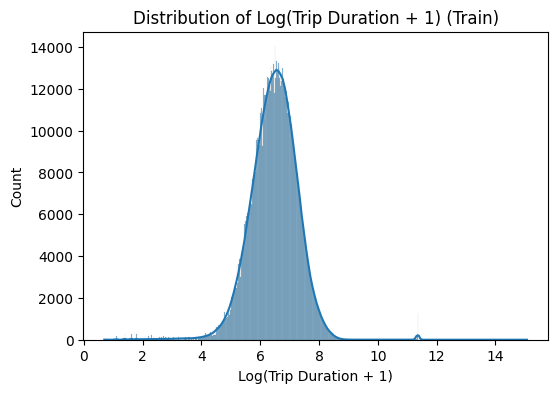

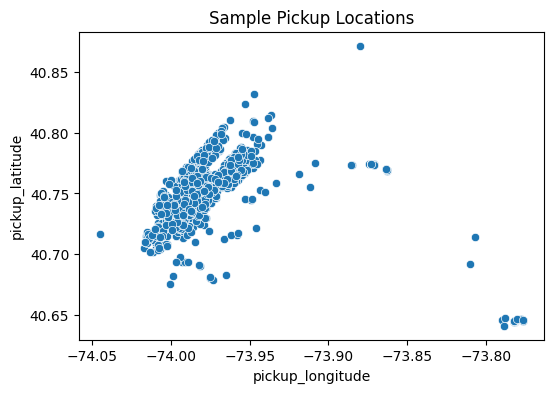

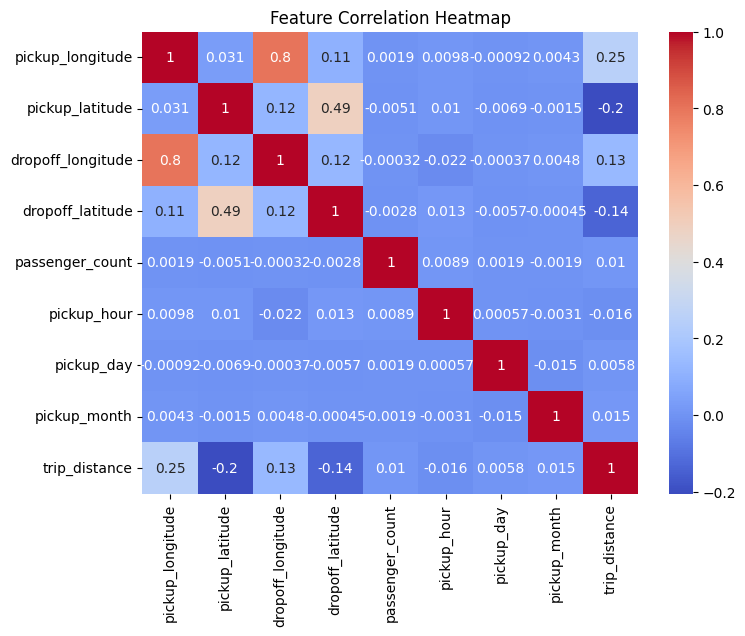

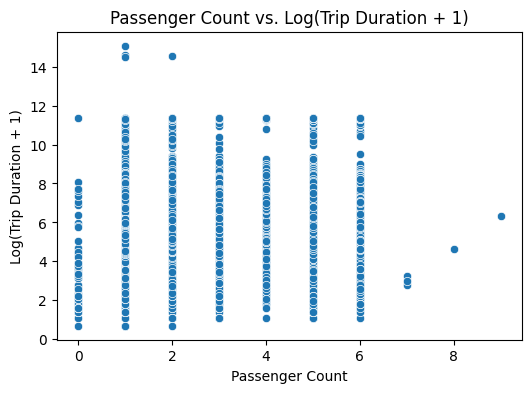

Training small model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 49: early stopping
Restoring model weights from the end of the best epoch: 44.
4559/4559 ━━━━━━━━━━━━━━━━━━━━ 4s 771us/step


/tmp/ipython-input-1113623310.py:112: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))


Small model Test RMSLE: 0.571
Training medium model...
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.
4559/4559 ━━━━━━━━━━━━━━━━━━━━ 4s 799us/step
Medium model Test RMSLE: 0.628
Training large model...
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.
4559/4559 ━━━━━━━━━━━━━━━━━━━━ 4s 829us/step
Large model Test RMSLE: 0.567


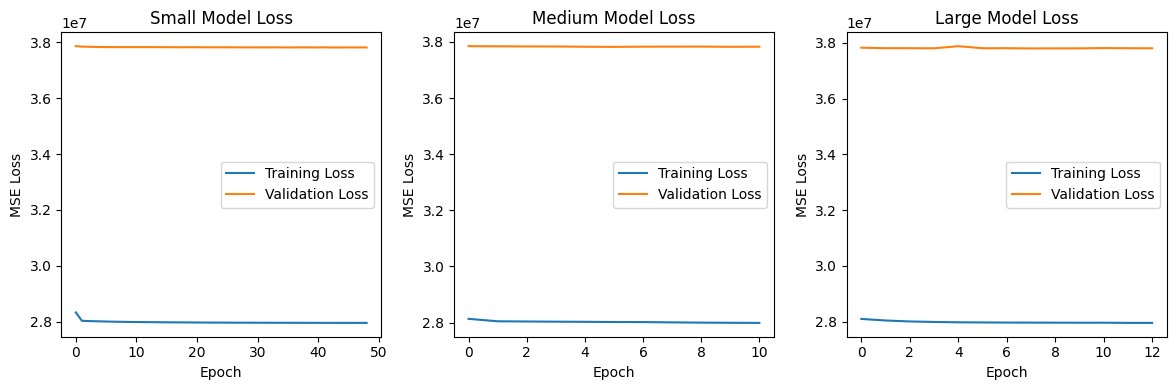


Benchmark Comparison:
       Model                         Architecture  Epochs (approx.) Test RMSLE
0  Benchmark                    3-layer NN (ReLU)                 7      0.513
1      Small                            Dense(50)                49      0.571
2     Medium               Dense(100) ➔ Dense(50)                11      0.628
3      Large  Dense(200) ➔ Dense(100) ➔ Dense(50)                13      0.567


In [19]:
###Dear TA, Running this part take 5 minutes. Thank you! mohsen

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive # mount Drive
drive.mount('/content/drive') # approve prompt
dataset = np.load('drive/MyDrive/nyc_taxi_data.npy', allow_pickle=True).item()

# file_path = "/Users/mohsenmohammadagha/Desktop/P/nyc_taxi_data.npy"
# data_dict = np.load(file_path, allow_pickle=True).item()


# X_train = data_dict["X_train"]
# y_train = data_dict["y_train"]
# X_test = data_dict["X_test"]
# y_test = data_dict["y_test"]

X_train = dataset["X_train"]
y_train = dataset["y_train"]
X_test  = dataset["X_test"]
y_test  = dataset["y_test"]




print("Training features sample:")
print(X_train.head())
print("\nTraining target sample:")
print(y_train.head())
for df in [X_train, X_test]:
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day'] = df['pickup_datetime'].dt.day
    df['pickup_month'] = df['pickup_datetime'].dt.month
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c
for df in [X_train, X_test]:
    df['trip_distance'] = haversine_distance(df['pickup_latitude'],
                                             df['pickup_longitude'],
                                             df['dropoff_latitude'],
                                             df['dropoff_longitude'])
features = ['pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude',
            'passenger_count', 'pickup_hour',
            'pickup_day', 'pickup_month', 'trip_distance']
X_train_features = X_train[features]
X_test_features = X_test[features]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)
plt.figure(figsize=(6,4))
sns.histplot(np.log1p(y_train), kde=True)
plt.title("Distribution of Log(Trip Duration + 1) (Train)")
plt.xlabel("Log(Trip Duration + 1)")
plt.show()
plt.figure(figsize=(6,4))
sns.scatterplot(x="pickup_longitude", y="pickup_latitude",
                data=X_train.sample(1000, random_state=42))
plt.title("Sample Pickup Locations")
plt.show()
plt.figure(figsize=(8,6))
corr = X_train_features.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()
plt.figure(figsize=(6,4))
sns.scatterplot(x=X_train["passenger_count"], y=np.log1p(y_train))
plt.title("Passenger Count vs. Log(Trip Duration + 1)")
plt.xlabel("Passenger Count")
plt.ylabel("Log(Trip Duration + 1)")
plt.show()
def create_model(model_type, input_dim):
    model = Sequential()
    if model_type == 'small':
        model.add(Dense(50, activation='relu', input_dim=input_dim))
    elif model_type == 'medium':
        model.add(Dense(100, activation='relu', input_dim=input_dim))
        model.add(Dense(50, activation='relu'))
    elif model_type == 'large':
        model.add(Dense(200, activation='relu', input_dim=input_dim))
        model.add(Dense(100, activation='relu'))
        model.add(Dense(50, activation='relu'))
    else:
        raise ValueError("Unknown model_type provided. Choose 'small', 'medium', or 'large'.")
    model.add(Dense(1))
    if model_type == 'small':
        lr = 0.001
    else:
        lr = 0.0005
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse')
    return model
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))
models = ['small', 'medium', 'large']
histories = {}
results = {}
input_dim = X_train_scaled.shape[1]
for model_type in models:
    print(f"Training {model_type} model...")
    model = create_model(model_type, input_dim)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    history = model.fit(X_train_scaled, y_train,
                        validation_split=0.1,
                        epochs=50,
                        batch_size=128,
                        callbacks=[early_stop],
                        verbose=0)
    histories[model_type] = history
    pred = model.predict(X_test_scaled).flatten()
    test_rmsle = rmsle(y_test, pred)
    results[model_type] = test_rmsle
    print(f"{model_type.capitalize()} model Test RMSLE: {test_rmsle:.3f}")
plt.figure(figsize=(12, 4))
for i, model_type in enumerate(models):
    plt.subplot(1, 3, i+1)
    plt.plot(histories[model_type].history['loss'], label='Training Loss')
    plt.plot(histories[model_type].history['val_loss'], label='Validation Loss')
    plt.title(f"{model_type.capitalize()} Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
plt.tight_layout()
plt.show()
benchmark_row = {
    "Model": "Benchmark",
    "Architecture": "3-layer NN (ReLU)",
    "Epochs (approx.)": 7,
    "Test RMSLE": "0.513"
}
comparison_df = pd.DataFrame({
    "Model": ["Benchmark", "Small", "Medium", "Large"],
    "Architecture": [
        "3-layer NN (ReLU)",
        "Dense(50)",
        "Dense(100) ➔ Dense(50)",
        "Dense(200) ➔ Dense(100) ➔ Dense(50)"
    ],
    "Epochs (approx.)": [benchmark_row["Epochs (approx.)"],
                         len(histories['small'].history['loss']),
                         len(histories['medium'].history['loss']),
                         len(histories['large'].history['loss'])],
    "Test RMSLE": [benchmark_row["Test RMSLE"],
                   f"{results['small']:.3f}",
                   f"{results['medium']:.3f}",
                   f"{results['large']:.3f}"]
})
print("\nBenchmark Comparison:")
print(comparison_df)
